In [1]:
import numpy as np

file = "../data/telco/npy/sms-call-internet-mi-2013-12-01.npy"    

with open(file, "rb") as f:
    data = np.load(f)

In [2]:
# Cols: 0-square_id, 1-timestamp, 2-country, 3-sms_in
#       4-sms_out, 5-calls_in, 6-calls_out, 7-data
data[2]

array([1.00000000e+00, 1.38585300e+12, 3.90000000e+01, 1.65136827e-01,
       1.76399458e-01, 3.08750851e-02, 2.73004649e-02, 1.33308582e+01])

In [3]:
data[:, 3].mean()

nan

In [4]:
np.nanmean(data[:, 3])

1.6845715599803395

In [5]:
np.nansum(data[:, 3:7], axis=0)

array([4432951.7446602 , 2665727.64981971, 2435220.40770108,
       2949631.54223634])

In [9]:
import os

DIR = "../data/telco/npy"
npy_files = os.listdir(DIR)
npy_files[:4]

['sms-call-internet-mi-2013-12-01.npy',
 'sms-call-internet-mi-2013-12-02.npy',
 'sms-call-internet-mi-2013-12-03.npy',
 'sms-call-internet-mi-2013-12-04.npy']

In [10]:
import dask.array as da

arrays = []
for array in npy_files:
    file = os.path.join(DIR, array)
    data = np.load(file, mmap_mode="r+")
    arr = da.from_array(data, chunks=(5_000_000, 8))
    arrays.append(arr)
del data, arr

a = da.concatenate(arrays)
a

dask.array<concatenate, shape=(26328276, 8), dtype=float64, chunksize=(5000000, 8), chunktype=numpy.ndarray>

In [11]:
%time da.to_npy_stack("../data/telco/stack", a)

CPU times: user 487 ms, sys: 1min 13s, total: 1min 13s
Wall time: 1min 20s


In [12]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:51588,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [13]:
import dask.array as da

In [14]:
arr = da.from_npy_stack("../data/telco/stack/")
arr

dask.array<from-npy-stack, shape=(26328276, 8), dtype=float64, chunksize=(5000000, 8), chunktype=numpy.ndarray>

In [15]:
task = da.nanmean(arr[:, 3])
task

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [16]:
# Direct imports:
from numpy import nanmean
from dask.array import nanmean

# Ugly 'cheating':
import numpy as np
import dask.array as np

In [17]:
task.compute()

2.4193478469199534

In [18]:
da.nansum(arr[:, 3:7], axis=0).compute()

array([33937602.72854328, 17870405.59281527, 23411051.70450182,
       26847876.72938447])

In [19]:
import pandas as pd

colnames = ["square_id", "timestamp", "country_prefix",
             "sms_out", "sms_in", "call_out", "call_in", "data"]

In [21]:
df = pd.read_csv(
        "../data/telco/txt/sms-call-internet-mi-2013-12-05.txt",
        delimiter="\t", header=None)
df.columns = colnames

In [22]:
df = df.assign(timestamp=pd.to_datetime(df["timestamp"], unit="ms"))
df.head()

,square_id,timestamp,country_prefix,sms_out,sms_in,call_out,call_in,data
0,1,2013-12-04 23:00:00,0,0.104550,NaN,NaN,NaN,NaN
1,1,2013-12-04 23:00:00,39,0.192891,0.247662,0.001787,0.052275,10.904829
2,1,2013-12-04 23:00:00,46,NaN,NaN,NaN,NaN,0.026137
3,1,2013-12-04 23:10:00,39,0.223937,0.357574,0.029088,0.053438,10.318298
4,1,2013-12-04 23:20:00,39,0.194763,0.092711,0.026137,NaN,10.665478


In [23]:
df = df.assign(hour=df["timestamp"].dt.hour)
df = df.drop(["square_id", "timestamp", "country_prefix", "data"], axis=1)

hour_sums = df.groupby("hour").sum()

hour_sums.head()

,sms_out,sms_in,call_out,call_in
hour,,,,
0,36252.047437,36756.129922,9227.043534,12387.645848
1,21671.756785,26988.754631,4472.234708,7489.672654
2,16090.884856,23618.373858,3223.207826,6466.023633
3,13589.358824,23163.086035,3629.389054,6837.319795
4,15660.686398,25014.991401,6087.555993,10543.414006


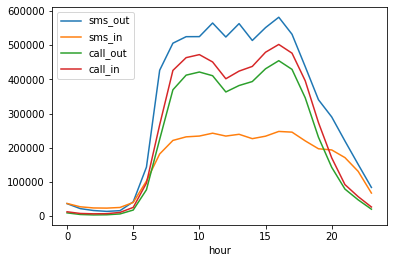

In [24]:
%matplotlib inline
hour_sums.plot()

In [25]:
import dask.dataframe as dd

df = dd.read_csv(
        "../data/telco/txt/sms-call-internet-mi-*",
        delimiter="\t", header=None)
df.columns = colnames
df

,square_id,timestamp,country_prefix,sms_out,sms_in,call_out,call_in,data
npartitions=29,,,,,,,,
,int64,int64,int64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [26]:
df = df.assign(timestamp=dd.to_datetime(df["timestamp"], unit="ms"))
df = df.assign(hour=df["timestamp"].dt.hour)
df = df.drop(["square_id", "timestamp", "country_prefix", "data"], axis=1)

In [27]:
task = df.groupby("hour").sum()
task

,sms_out,sms_in,call_out,call_in
npartitions=1,,,,
,float64,float64,float64,float64
,...,...,...,...


In [28]:
result = task.compute()

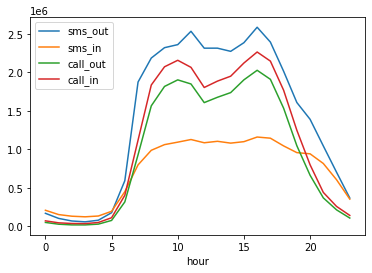

In [29]:
%matplotlib inline
result.plot()